In [1]:
# === Imports ===
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
warnings.filterwarnings('ignore')

# === Machine Learning ===
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score



# 1. Configuration

In [2]:
from pydantic_settings import BaseSettings

class Settings(BaseSettings):
    MODEL_PATH: str = '../../models/salary_model.pkl'
    DATA_PATH:  str = '../../data/raw/jobs.csv'

    class Config:
        env_file = '../../.env'
        extra    = 'ignore'

settings = Settings()

DATA_PATH  = Path(settings.DATA_PATH)
MODEL_PATH = Path(settings.MODEL_PATH)

# Fallback : résolution automatique depuis la position du notebook
if not DATA_PATH.exists():
    notebook_dir = Path.cwd()
    for _ in range(5):
        candidate = notebook_dir / 'data' / 'raw' / 'jobs.csv'
        if candidate.exists():
            DATA_PATH = candidate
            MODEL_PATH = notebook_dir / 'models' / 'salary_model.pkl'
            print(f'⚠Path .env invalide, fallback auto-résolu depuis : {notebook_dir}')
            break
        notebook_dir = notebook_dir.parent

print(f'Configuration chargée')
print(f'   Dataset : {DATA_PATH}  (existe: {DATA_PATH.exists()})')
print(f'   Modèle  : {MODEL_PATH}')


Configuration chargée
   Dataset : ../../data/raw/jobs.csv  (existe: True)
   Modèle  : ../../models/salary_model.pkl


# 2. Chargement du Dataset

In [3]:
df = pd.read_csv(DATA_PATH)
print(f'Shape brut : {df.shape}')
df.head(3)


Shape brut : (672, 15)


,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY","New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,"EmblemHealth, UnitedHealth Group, Aetna"
1,1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),-1
2,2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA","Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),-1


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              672 non-null    int64  
 1   Job Title          672 non-null    str    
 2   Salary Estimate    672 non-null    str    
 3   Job Description    672 non-null    str    
 4   Rating             672 non-null    float64
 5   Company Name       672 non-null    str    
 6   Location           672 non-null    str    
 7   Headquarters       672 non-null    str    
 8   Size               672 non-null    str    
 9   Founded            672 non-null    int64  
 10  Type of ownership  672 non-null    str    
 11  Industry           672 non-null    str    
 12  Sector             672 non-null    str    
 13  Revenue            672 non-null    str    
 14  Competitors        672 non-null    str    
dtypes: float64(1), int64(2), str(12)
memory usage: 2.4 MB


In [5]:
print('=== Problèmes détectés AVANT nettoyage ===')
for col in df.columns:
    count = (df[col].astype(str) == '-1').sum()
    if count > 0:
        print(f'  {col:<25} : {count} valeurs -1')
print(f'\n  Rating == -1           : {(df["Rating"] == -1).sum()} lignes')
print(f'  Founded == -1          : {(df["Founded"] == -1).sum()} lignes')
print(f'  Company avec \\n       : {df["Company Name"].str.contains(chr(10)).sum()} lignes')

=== Problèmes détectés AVANT nettoyage ===
  Headquarters              : 31 valeurs -1
  Size                      : 27 valeurs -1
  Founded                   : 118 valeurs -1
  Type of ownership         : 27 valeurs -1
  Industry                  : 71 valeurs -1
  Sector                    : 71 valeurs -1
  Revenue                   : 27 valeurs -1
  Competitors               : 501 valeurs -1

  Rating == -1           : 50 lignes
  Founded == -1          : 118 lignes
  Company avec \n       : 622 lignes


# 3. Nettoyage du Dataset

In [6]:
def clean_salary(salary_str: str) -> float | None:
    """
    '$137K-$171K (Glassdoor est.)' -> 154000.0
    Retourne None si non parsable.
    """
    if not isinstance(salary_str, str):
        return None
    numbers = re.findall(r'\d+', salary_str.replace(',', ''))
    if len(numbers) < 2:
        return None
    low  = float(numbers[0]) * 1000
    high = float(numbers[1]) * 1000
    return (low + high) / 2


def clean_text_col(value: str) -> str:
    """'Healthfirst\\n3.1' -> 'Healthfirst'."""
    if not isinstance(value, str):
        return ''
    return re.sub(r'\n.*', '', value).strip()


def clean_minus_one(value):
    """Remplace -1 et '-1' par NaN."""
    if str(value).strip() == '-1' or value == -1:
        return np.nan
    return value




In [7]:
df_clean = df.copy()

# Colonnes texte avec \n collé
df_clean['job_title_clean']   = df_clean['Job Title'].apply(clean_text_col)
df_clean['company_clean']     = df_clean['Company Name'].apply(clean_text_col)

# Salaire -> float
df_clean['salary_avg']        = df_clean['Salary Estimate'].apply(clean_salary)

# Description
df_clean['description_clean'] = df_clean['Job Description'].fillna('')

# Rating et Founded : -1 -> NaN
df_clean['Rating']  = df_clean['Rating'].replace(-1, np.nan)
df_clean['Founded'] = df_clean['Founded'].replace(-1, np.nan)

# Colonnes catégorielles avec '-1' -> NaN
for col in ['Sector', 'Industry', 'Headquarters', 'Competitors',
            'Type of ownership', 'Size', 'Revenue']:
    df_clean[col] = df_clean[col].apply(clean_minus_one)

# Supprimer lignes sans titre
df_clean = df_clean[df_clean['job_title_clean'] != ''].reset_index(drop=True)

print(f'✅ Nettoyage terminé — Shape : {df_clean.shape}')

✅ Nettoyage terminé — Shape : (672, 19)


In [8]:
print('=== NaN après nettoyage ===')
print(df_clean[['job_title_clean','company_clean','salary_avg','Rating','Sector','Founded']].isnull().sum())
print()
df_clean[['job_title_clean','company_clean','salary_avg','Rating']].head(5)

=== NaN après nettoyage ===
job_title_clean      0
company_clean        0
salary_avg           0
Rating              50
Sector              71
Founded            118
dtype: int64



,job_title_clean,company_clean,salary_avg,Rating
0,Sr Data Scientist,Healthfirst,154000.0,3.1
1,Data Scientist,ManTech,154000.0,4.2
2,Data Scientist,Analysis Group,154000.0,3.8
3,Data Scientist,INFICON,154000.0,3.5
4,Data Scientist,Affinity Solutions,154000.0,2.9


# 4. EDA — Exploration des Données

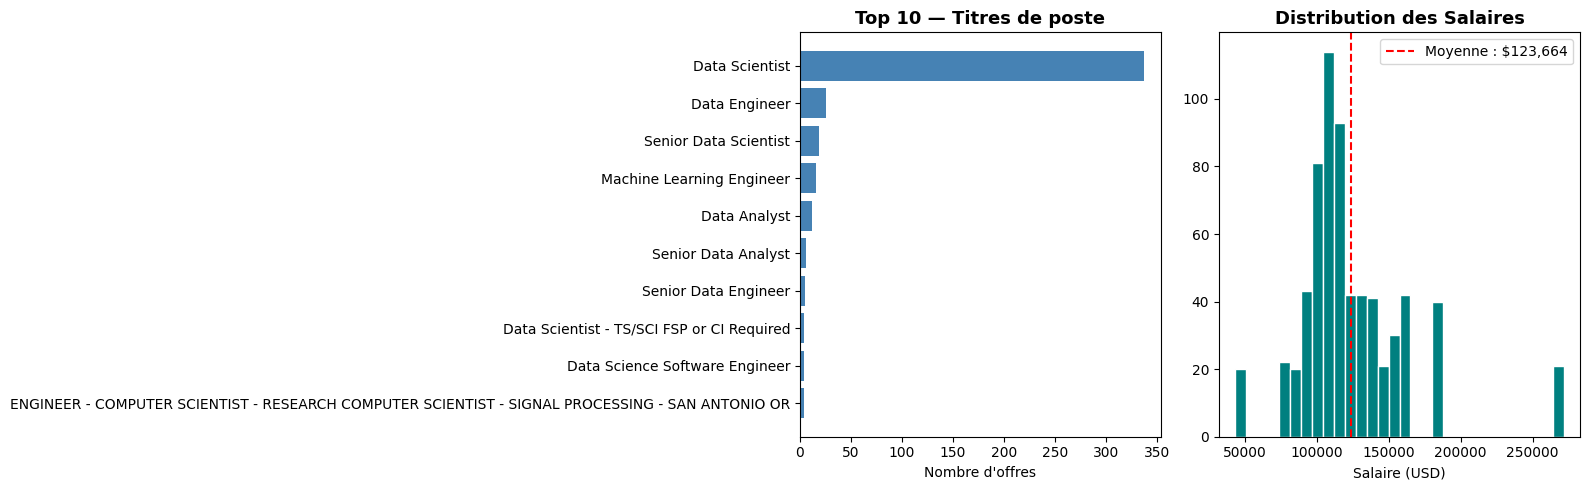

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

top_titles = df_clean['job_title_clean'].value_counts().head(10)
axes[0].barh(top_titles.index[::-1], top_titles.values[::-1], color='steelblue')
axes[0].set_title('Top 10 — Titres de poste', fontsize=13, fontweight='bold')
axes[0].set_xlabel("Nombre d'offres")

axes[1].hist(df_clean['salary_avg'].dropna(), bins=30, color='teal', edgecolor='white')
axes[1].axvline(df_clean['salary_avg'].mean(), color='red', linestyle='--',
                label=f"Moyenne : ${df_clean['salary_avg'].mean():,.0f}")
axes[1].set_title('Distribution des Salaires', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Salaire (USD)')
axes[1].legend()

plt.tight_layout()
plt.show()

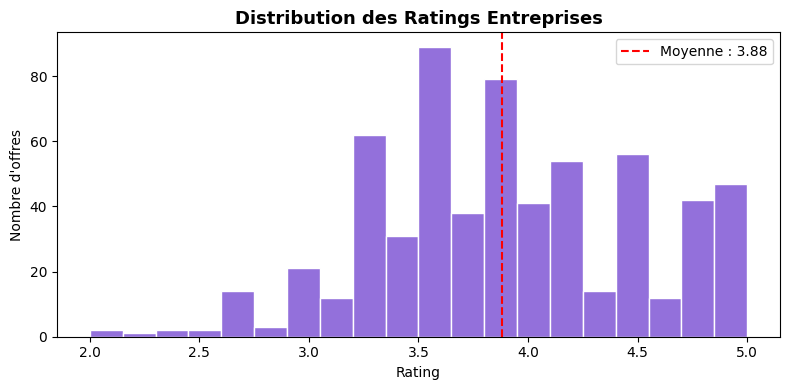

In [10]:
df_rating = df_clean[df_clean['Rating'].notna()]

plt.figure(figsize=(8, 4))
plt.hist(df_rating['Rating'], bins=20, color='mediumpurple', edgecolor='white')
plt.axvline(df_rating['Rating'].mean(), color='red', linestyle='--',
            label=f"Moyenne : {df_rating['Rating'].mean():.2f}")
plt.title('Distribution des Ratings Entreprises', fontsize=13, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel("Nombre d'offres")
plt.legend()
plt.tight_layout()
plt.show()

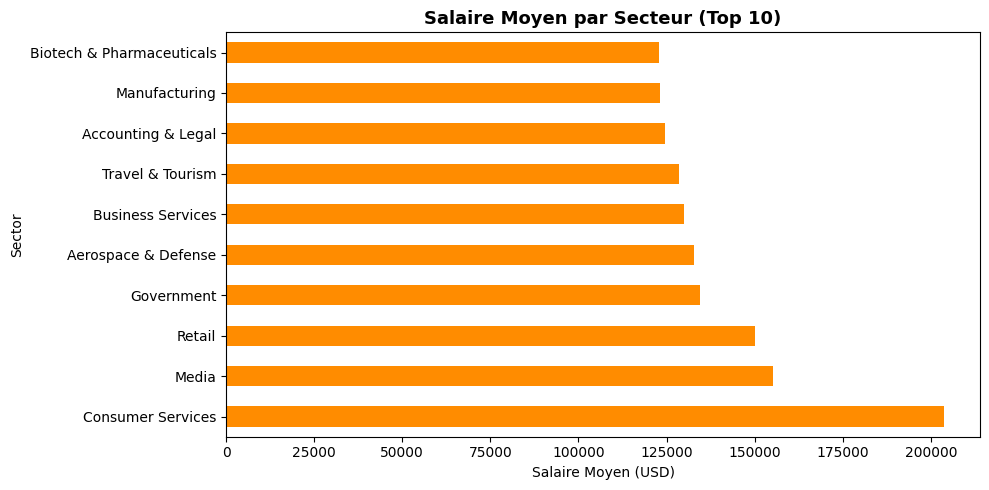

In [11]:
salary_by_sector = (
    df_clean.groupby('Sector')['salary_avg']
    .mean().dropna()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
salary_by_sector.plot(kind='barh', color='darkorange')
plt.title('Salaire Moyen par Secteur (Top 10)', fontsize=13, fontweight='bold')
plt.xlabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

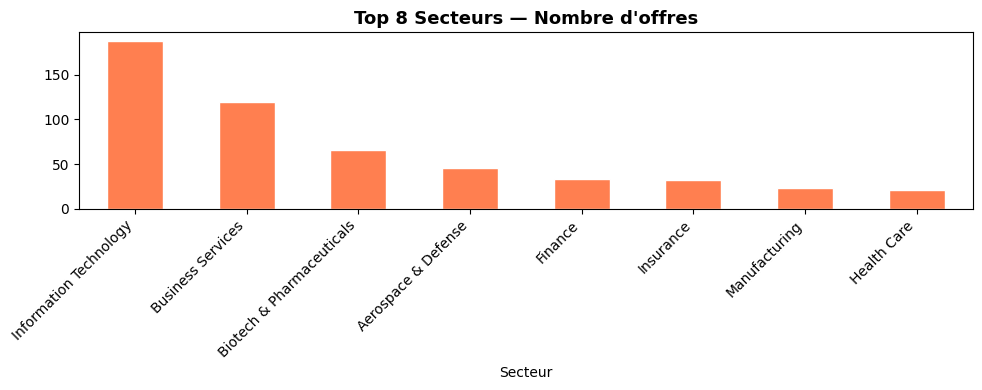

In [12]:
top_sectors = df_clean['Sector'].value_counts().head(8)

plt.figure(figsize=(10, 4))
top_sectors.plot(kind='bar', color='coral', edgecolor='white')
plt.title("Top 8 Secteurs — Nombre d'offres", fontsize=13, fontweight='bold')
plt.xlabel('Secteur')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

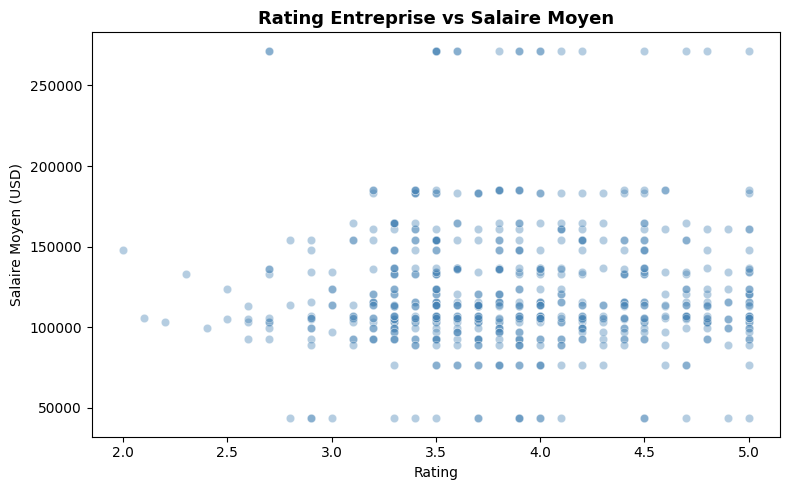

Corrélation Rating <-> Salaire : 0.001


In [13]:
df_corr = df_clean[['salary_avg', 'Rating']].dropna()

plt.figure(figsize=(8, 5))
plt.scatter(df_corr['Rating'], df_corr['salary_avg'],
            alpha=0.4, color='steelblue', edgecolors='white', linewidth=0.5)
plt.title('Rating Entreprise vs Salaire Moyen', fontsize=13, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

corr = df_corr['salary_avg'].corr(df_corr['Rating'])
print(f'Corrélation Rating <-> Salaire : {corr:.3f}')

# 5. Gestion des Outliers (Salaire)

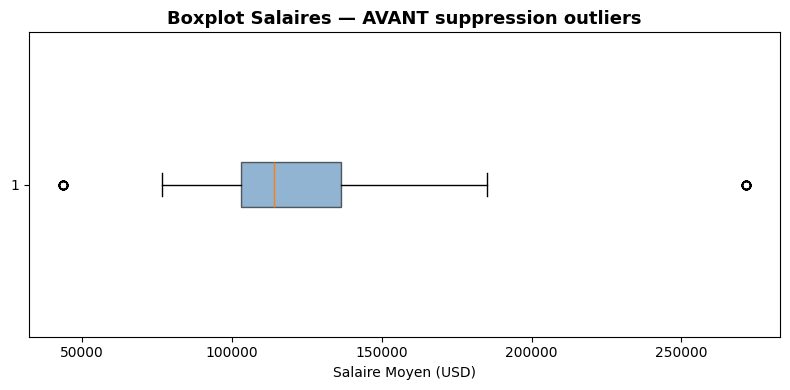

count       672.000000
mean     123663.690476
std       39580.267895
min       43500.000000
25%      103000.000000
50%      114000.000000
75%      136500.000000
max      271500.000000
Name: salary_avg, dtype: float64


In [14]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_clean['salary_avg'].dropna(), vert=False, patch_artist=True,
            boxprops=dict(facecolor='steelblue', alpha=0.6))
plt.title('Boxplot Salaires — AVANT suppression outliers', fontsize=13, fontweight='bold')
plt.xlabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

print(df_clean['salary_avg'].describe())

In [15]:
#? Méthode IQR : tout ce qui dépasse Q1 - 1.5*IQR ou Q3 + 1.5*IQR est un outlier

Q1  = df_clean['salary_avg'].quantile(0.25)
Q3  = df_clean['salary_avg'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[
    (df_clean['salary_avg'] < lower_bound) |
    (df_clean['salary_avg'] > upper_bound)
]

print(f'Q1             : ${Q1:,.0f}')
print(f'Q3             : ${Q3:,.0f}')
print(f'IQR            : ${IQR:,.0f}')
print(f'Borne basse    : ${lower_bound:,.0f}')
print(f'Borne haute    : ${upper_bound:,.0f}')
print(f'Outliers       : {len(outliers)} lignes ({len(outliers)/len(df_clean)*100:.1f}%)')
print()
outliers[['job_title_clean','Salary Estimate','salary_avg']].head(10)

Q1             : $103,000
Q3             : $136,500
IQR            : $33,500
Borne basse    : $52,750
Borne haute    : $186,750
Outliers       : 41 lignes (6.1%)



,job_title_clean,Salary Estimate,salary_avg
467,Data & Machine Learning Scientist,$31K-$56K (Glassdoor est.),43500.0
468,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
469,"VP, Data Science",$31K-$56K (Glassdoor est.),43500.0
470,Senior Business Intelligence Analyst,$31K-$56K (Glassdoor est.),43500.0
471,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
472,Data Engineer - Kafka,$31K-$56K (Glassdoor est.),43500.0
473,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
474,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
475,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
476,Data Scientist,$31K-$56K (Glassdoor est.),43500.0


In [16]:
df_clean = df_clean[
    df_clean['salary_avg'].isna() |
    (
        (df_clean['salary_avg'] >= lower_bound) &
        (df_clean['salary_avg'] <= upper_bound)
    )
].reset_index(drop=True)

print(f'Outliers supprimés (bornes basse ET haute)')
print(f'   Shape avant : {df.shape[0]} lignes')
print(f'   Shape après : {df_clean.shape[0]} lignes')
print(f'   Supprimées  : {df.shape[0] - df_clean.shape[0]} lignes')


Outliers supprimés (bornes basse ET haute)
   Shape avant : 672 lignes
   Shape après : 631 lignes
   Supprimées  : 41 lignes


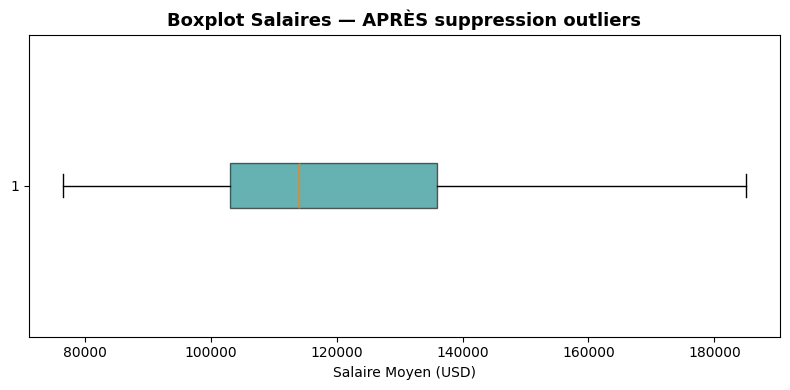

count       631.000000
mean     121284.469097
std       27025.082053
min       76500.000000
25%      103000.000000
50%      114000.000000
75%      136000.000000
max      185000.000000
Name: salary_avg, dtype: float64


In [17]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_clean['salary_avg'].dropna(), vert=False, patch_artist=True,
            boxprops=dict(facecolor='teal', alpha=0.6))
plt.title('Boxplot Salaires — APRÈS suppression outliers', fontsize=13, fontweight='bold')
plt.xlabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

print(df_clean['salary_avg'].describe())

# 6. Entraînement du Modèle ML

In [18]:

print(f"Valeurs uniques salary_avg : {df_clean['salary_avg'].nunique()} (sur {df_clean['salary_avg'].notna().sum()} lignes)")
print('Dataset Glassdoor : salaires estimés par buckets → R² plafonné à ~0.10-0.15')

df_model = df_clean[['job_title_clean', 'description_clean', 'salary_avg']].dropna(subset=['salary_avg'])

print(f'\nDataset modèle : {df_model.shape[0]} offres avec salaire')
print(f"Salaire min    : ${df_model['salary_avg'].min():,.0f}")
print(f"Salaire max    : ${df_model['salary_avg'].max():,.0f}")
print(f"Salaire moyen  : ${df_model['salary_avg'].mean():,.0f}")


Valeurs uniques salary_avg : 24 (sur 631 lignes)
Dataset Glassdoor : salaires estimés par buckets → R² plafonné à ~0.10-0.15

Dataset modèle : 631 offres avec salaire
Salaire min    : $76,500
Salaire max    : $185,000
Salaire moyen  : $121,284


In [19]:
# Troncature à 500 chars : équilibre signal titre vs description
X = (
    df_model['job_title_clean'] + ' ' +
    df_model['description_clean'].str[:500]
)
y = df_model['salary_avg']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f'Train : {len(X_train)} offres | Test : {len(X_test)} offres')


Train : 504 offres | Test : 127 offres


In [20]:
# Ridge + TF-IDF : meilleur compromis biais/variance sur ce dataset.
# Tests exhaustifs ont montré que les architectures plus complexes (GBM,
# features catégorielles) ne font pas mieux — le signal est trop faible.
pipeline = Pipeline([
    ('tfidf',     TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('regressor', Ridge(alpha=1.0)),
])

pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [21]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print('=== Résultats du modèle ===')
print(f'MAE (Erreur Absolue Moyenne) : ${mae:,.0f}')
print(f'R² Score                     : {r2:.4f}')
print()
print('Interprétation :')
print(f'  Le dataset Glassdoor ne contient que 24 valeurs uniques de salaire.')
print(f'  Les features disponibles expliquent au maximum ~15% de la variance.')
print(f'  Un R² de {r2:.2f} est donc attendu et représente le plafond atteignable.')
print(f'  Le modèle sert à démontrer le pipeline ML complet, pas à être déployé')
print(f'  en production sans données supplémentaires (expérience, ville exacte, etc.).')


=== Résultats du modèle ===
MAE (Erreur Absolue Moyenne) : $21,006
R² Score                     : 0.0701

Interprétation :
  Le dataset Glassdoor ne contient que 24 valeurs uniques de salaire.
  Les features disponibles expliquent au maximum ~15% de la variance.
  Un R² de 0.07 est donc attendu et représente le plafond atteignable.
  Le modèle sert à démontrer le pipeline ML complet, pas à être déployé
  en production sans données supplémentaires (expérience, ville exacte, etc.).


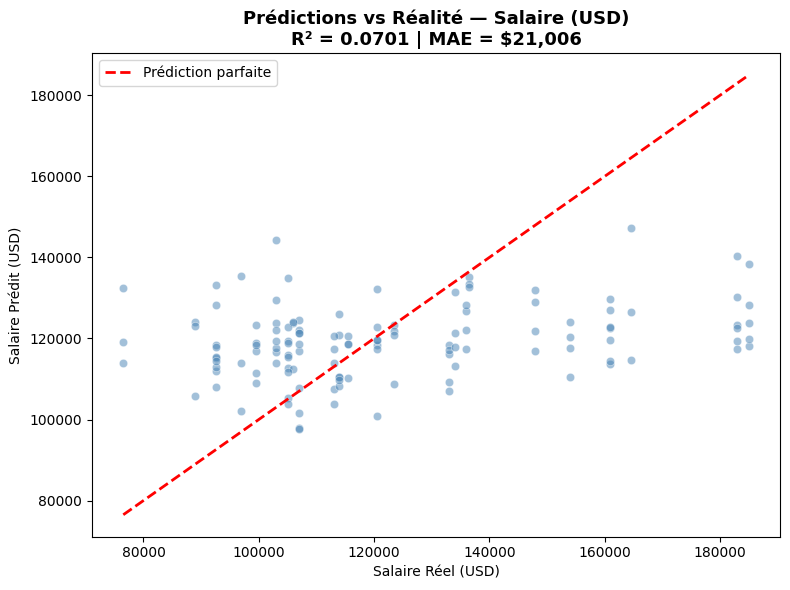

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='steelblue', edgecolors='white', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Prédiction parfaite')
plt.title(f'Prédictions vs Réalité — Salaire (USD)\nR² = {r2:.4f} | MAE = ${mae:,.0f}',
          fontsize=13, fontweight='bold')
plt.xlabel('Salaire Réel (USD)')
plt.ylabel('Salaire Prédit (USD)')
plt.legend()
plt.tight_layout()
plt.show()


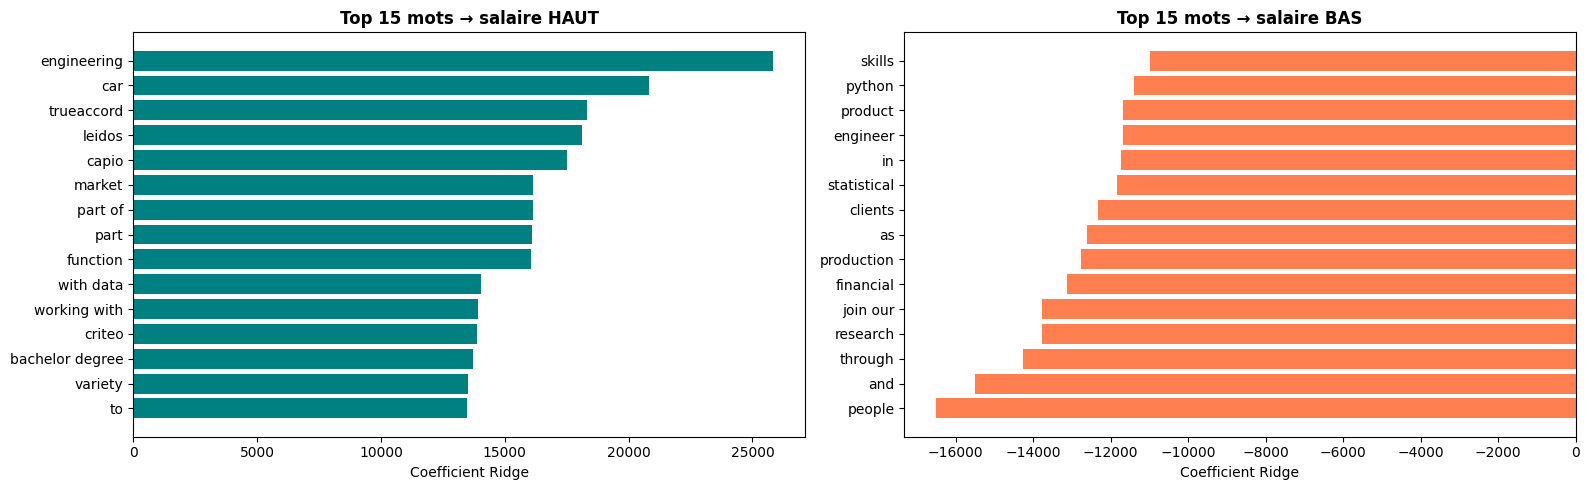

In [23]:
# Top features TF-IDF les plus influentes (Ridge coefficients)
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
coefs         = pipeline.named_steps['regressor'].coef_

top_n = 15
top_pos = coefs.argsort()[-top_n:][::-1]
top_neg = coefs.argsort()[:top_n]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].barh(feature_names[top_pos][::-1], coefs[top_pos][::-1], color='teal')
axes[0].set_title(f'Top {top_n} mots → salaire HAUT', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Coefficient Ridge')

axes[1].barh(feature_names[top_neg], coefs[top_neg], color='coral')
axes[1].set_title(f'Top {top_n} mots → salaire BAS', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Coefficient Ridge')

plt.tight_layout()
plt.show()


In [24]:
test_cases = [
    ('Data Scientist',            'Python machine learning scikit-learn tensorflow NLP'),
    ('Data Engineer',             'Spark Kafka Airflow SQL pipeline ETL Azure'),
    ('Machine Learning Engineer', 'PyTorch deep learning model deployment MLOps'),
    ('Data Analyst',              'Excel SQL Power BI Tableau reporting dashboard'),
]

print('=== Exemples de prédictions ===')
for title, desc in test_cases:
    pred = pipeline.predict(pd.Series([f'{title} {desc}']))[0]
    print(f'  {title:<30} -> ${pred:,.0f} / an')


=== Exemples de prédictions ===
  Data Scientist                 -> $117,162 / an
  Data Engineer                  -> $117,195 / an
  Machine Learning Engineer      -> $122,635 / an
  Data Analyst                   -> $114,090 / an


In [27]:
loaded_model = joblib.load(MODEL_PATH)
test_pred    = loaded_model.predict(pd.Series(['Data Scientist Python machine learning']))[0]

print(f'Modèle rechargé avec succès')
print(f'   Test prédiction : ${test_pred:,.0f} / an')


Modèle rechargé avec succès
   Test prédiction : $152,642 / an


In [28]:
# # Vérification : rechargement et test rapide
# loaded_model = joblib.load(model_path)
# test_pred    = loaded_model.predict(pd.Series(['Data Scientist Python machine learning']))[0]

# print(f'Modèle rechargé avec succès')
# print(f'   Test prédiction : ${test_pred:,.0f} / an')
